In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [2]:
# Load document vectors and labels tensors from specified files
document_vectors_tensor = torch.load('../data/document_vectors_emb_tensor.pt')
labels_tensor = torch.load('../data/labels_emb_tensor.pt')

In [3]:
# Splitting data into training and test/validation sets
train_data, test_val_data, train_labels, test_val_labels = train_test_split(document_vectors_tensor, labels_tensor, train_size=0.7, random_state=24, stratify=labels_tensor)

In [4]:
# Further splitting the test/validation data into test and validation sets
test_data, val_data, test_labels, val_labels = train_test_split(test_val_data, test_val_labels, train_size=0.5, random_state=24, stratify=test_val_labels)

In [5]:
# Standardizing the data
mean = torch.mean(train_data, dim=0)
std = torch.std(train_data, dim=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std
val_data = (val_data - mean) / std

In [6]:
# Creating datasets
train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(val_data, val_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size = 64

# Creating data loaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [7]:
class SeqModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Define the neural network layers
        self.fc1 = nn.Linear(100, 128)  # Input size: 100, Output size: 128
        self.fc2 = nn.Linear(128, 64)   # Input size: 128, Output size: 64
        self.fc3 = nn.Linear(64, 6)     # Input size: 64, Output size: 6
        self.act = nn.ReLU()            # Activation function: ReLU
        self.dropout = nn.Dropout(p=0.2)  # Dropout layer with a dropout probability of 0.2 (p)

    def forward(self, x):
        # Forward pass through the network
        out = self.fc1(x)    # Input x is passed through the first fully connected layer
        out = self.act(out)  # Activation function applied
        out = self.fc2(out)  # Output of the first layer passed through the second fully connected layer
        out = self.act(out)  # Activation function applied
        out = self.fc3(out)  # Output of the second layer passed through the third fully connected layer

        return out

In [8]:
# Function for training the neural network
def training_loop(n_epochs, optimizer, model, criterion, train_loader, val_loader=None):
    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        loss_train = 0.0
        for data, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        avg_loss_train = loss_train / len(train_loader)
        train_losses.append(avg_loss_train)

        if val_loader is not None:
            val_loss = 0.0
            with torch.no_grad():
                for val_data, val_labels in val_loader:
                    val_outputs = model(val_data)
                    val_loss += criterion(val_outputs, val_labels).item()
            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

        if epoch == 0 or (epoch + 1) % 10 == 0:
            print('{} Epoch {}, Training loss: {:.4f}'.format(
                datetime.datetime.now(), epoch + 1, avg_loss_train))
            if val_loader is not None:
                print('{} Epoch {}, Validation loss: {:.4f}'.format(
                    datetime.datetime.now(), epoch + 1, avg_val_loss))

    return train_losses, val_losses

In [9]:
# Function to plot training and, optionally, validation losses
def plot_losses(train_losses, val_losses=None):
    plt.plot(train_losses, label='Training loss')
    if val_losses:
        plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses')
    plt.show()

In [10]:
# Set the number of epochs, batch size, and learning rate
n_epochs = 14
batch_size = 64
learning_rate = 0.055

# Instantiate the model
model = SeqModel()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [11]:
# Perform training loop
train_losses, val_losses = training_loop(n_epochs, optimizer, model, criterion, train_loader, val_loader)

2024-04-11 22:49:09.348845 Epoch 1, Training loss: 0.7922
2024-04-11 22:49:09.349018 Epoch 1, Validation loss: 0.6812
2024-04-11 22:49:31.954556 Epoch 10, Training loss: 0.5150
2024-04-11 22:49:31.954647 Epoch 10, Validation loss: 0.5507


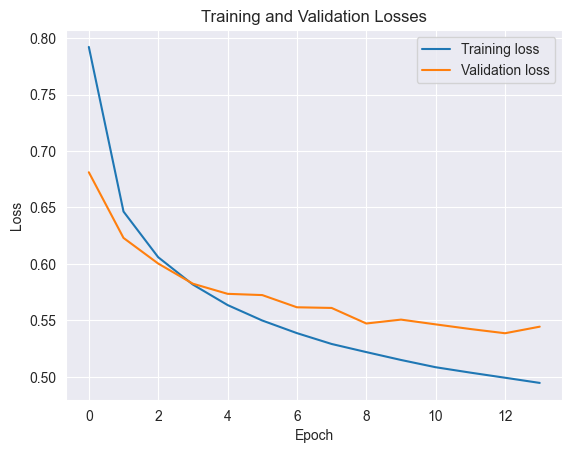

In [12]:
# Plot training and validation losses
plot_losses(train_losses, val_losses)

In [13]:
# Evaluate model performance on the validation set
val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for val_data, val_labels in val_loader:
        val_outputs = model(val_data)
        val_loss += criterion(val_outputs, val_labels).item()
        _, predicted = torch.max(val_outputs, 1)
        total += val_labels.size(0)
        correct += (predicted == val_labels).sum().item()

print('Validation loss: {:.4f}'.format(val_loss / len(val_loader)))
print('Validation accuracy: {:.2f}%'.format(100 * correct / total))

Validation loss: 0.5445
Validation accuracy: 78.46%


In [14]:
# Evaluate model performance on the test set
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for t_data, t_labels in test_loader:
        t_outputs = model(t_data)
        test_loss += criterion(t_outputs, t_labels).item()
        _, predicted = torch.max(t_outputs, 1)
        total += t_labels.size(0)
        correct += (predicted == t_labels).sum().item()

print('Test loss: {:.4f}'.format(test_loss / len(test_loader)))
print('Test accuracy: {:.2f}%'.format(100 * correct / total))

Test loss: 0.5479
Test accuracy: 78.29%


In [15]:
# Make predictions on the test set
model.eval()
predictions = []

with torch.no_grad():
    for data, _ in test_loader:
        outputs = model(data)
        predictions.extend(outputs.tolist())

# Convert predictions to tensor and determine predicted classes
probs = torch.tensor(predictions)
predicted_classes = torch.argmax(probs, dim=1)

In [16]:
# Print classification report
print(classification_report(predicted_classes, test_labels))

              precision    recall  f1-score   support

           0       0.79      0.84      0.81     17093
           1       0.86      0.83      0.84     21900
           2       0.64      0.68      0.66      4830
           3       0.74      0.75      0.75      8534
           4       0.77      0.67      0.72      8309
           5       0.54      0.66      0.59      1851

    accuracy                           0.78     62517
   macro avg       0.72      0.74      0.73     62517
weighted avg       0.79      0.78      0.78     62517



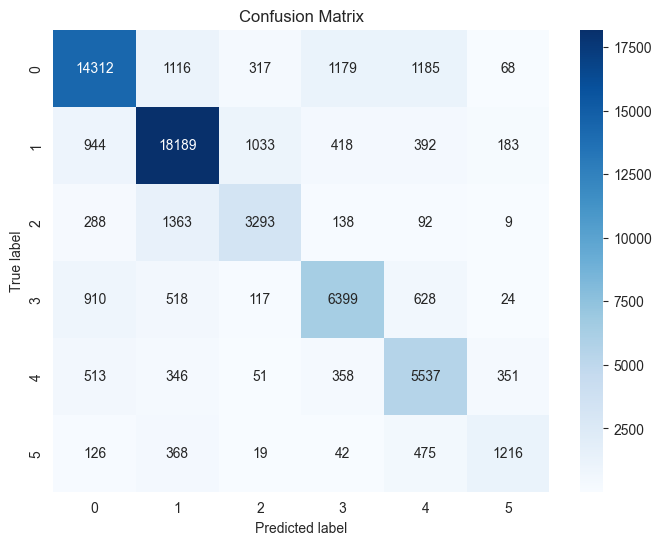

In [17]:
# Generate confusion matrix and visualize it
conf_matrix = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()